In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 

import time

import os
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

#import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

c:\Users\wende\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Não foi possível encontrar o procedimento especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Definindo o solver de EDO, por questões de simplicidade utilizaremos o método de Euler.

In [2]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

Agora, definimos as classes importantes para implementação do método da adjunta.

In [3]:
###################### ODEFunction useful methods ######################
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

###################### ODEAdjoint from f ######################
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Encapsulando a rede neural que será colocada na f, já com o método foward:

In [4]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Aplicação
## Aprendendo uma dinâmica dada

Como prova de conceito do modelo, geraremos pontos apartir de uma dinâmica pré estabelecida e usaremos o modelo para reaprender essa dinâmica. Para esse primeiro caso já começamos com uma função que é linear bonitinha mas com suas entradas aleatórias.

A dinâmica a ser aprendida é uma EDO simples linear, definida pela matriz
$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z
$$


In [5]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)


Função espiral real:

In [6]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

Dinâmica linear inicial aleatória que será otimizada:

In [7]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

Definindo as funções que plotam nossa dinêmica real e a aprendida ao longo do treinamento

In [8]:
def to_np(x):
    return x.detach().cpu().numpy()
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [9]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create the directory if it does not exist
    save_dir = f"assets/imgs/{name}/"
    os.makedirs(save_dir, exist_ok=True)

    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"{save_dir}/{i}.png")
            clear_output(wait=True)

In [10]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

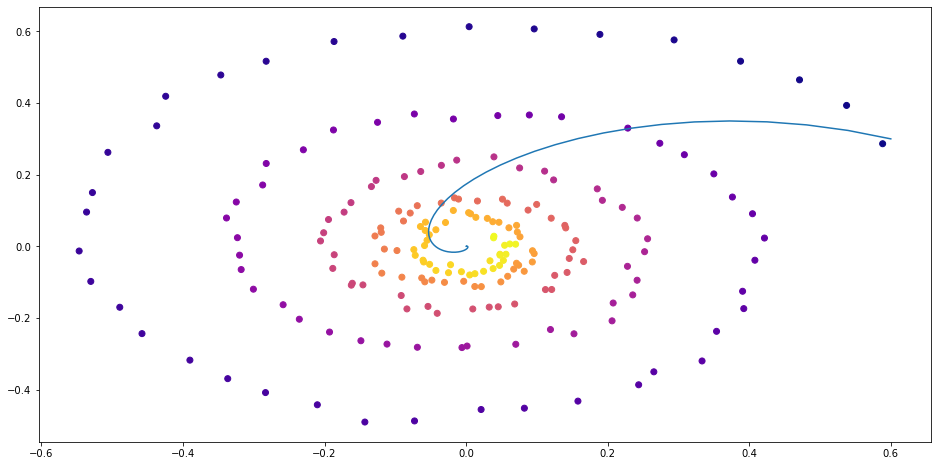

In [11]:
conduct_experiment(ode_true, ode_trained, 1000, "linear")

Como visto nesse caso mais simples o método foi capaz de aprender a dinâmica da espiral, agora testaremos em uma dinâmica um pouquinho mais complicada(definida a partir de um MLP):

![complicated result](assets/comp_result.png)

Definindo a função pra criar as trajetórias:

In [23]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

Função a ser otimizada(também um MLP):

In [24]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

Definindo a dinâmica a ser aprendida, inicializando aleatoriamente a dinâmica a ser treinada e prosseguindo para o treinamento:

In [25]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

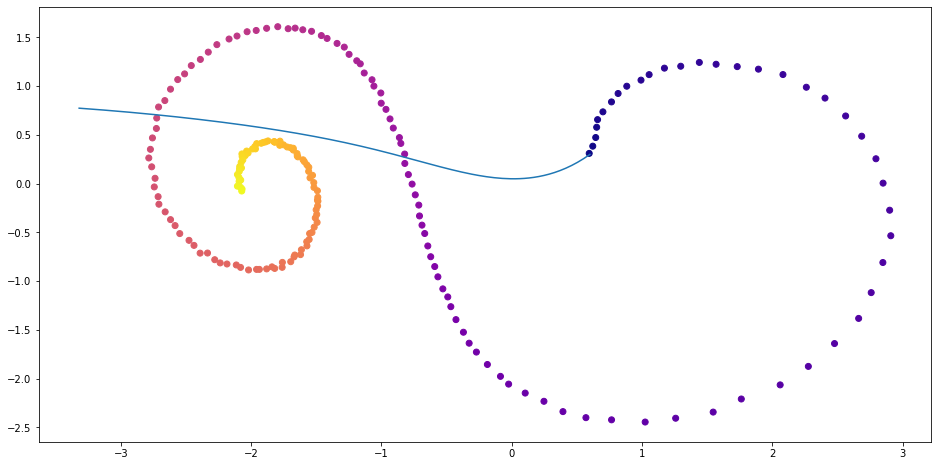

In [26]:
conduct_experiment(ode_true, ode_trained, 100, "comp")

Como vimos, o modelo foi capaz de aprender essas duas dinâmicas muito bem, agora podemos testar essa arquitetura em uma tarefe um tanto mais complicada.

# Testando ODENets no MNIST


<img src="assets/mnist_example.png" width=400></img>

In [27]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [28]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [29]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [30]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [31]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

In [48]:
optimizer = torch.optim.Adam(model.parameters())

In [33]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [34]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

Testing...


C:\Users\wende\AppData\Local\Temp/ipykernel_9724/3269749619.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 10.100%
Training Epoch 1...


C:\Users\wende\AppData\Local\Temp/ipykernel_9724/144190416.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.16039
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 97.900%
Training Epoch 2...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.05036
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.770%
Training Epoch 3...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03888
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.910%
Training Epoch 4...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03022
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.900%
Training Epoch 5...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02409
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.170%


<AxesSubplot:title={'center':'train error'}, xlabel='cum_data'>

<Figure size 648x360 with 0 Axes>

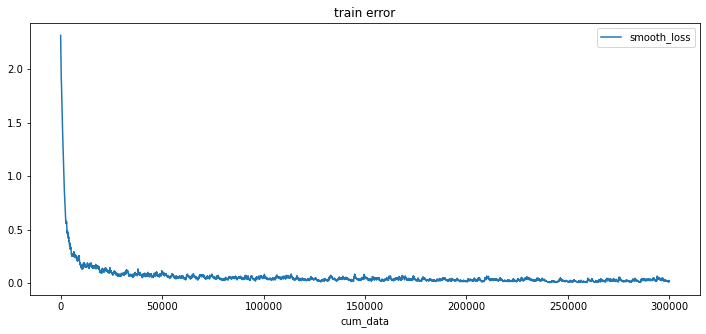

In [35]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

# Implementando ODENets para os datasets vistos nas listas

## BreastCancer dataset

Agora, comparando esse modelo com um dos modelos implmementados em aula, a classificação binária no dataset breast cancer, na lista de exercício o modelo com o melhor desempenho foi a estimativa de máximo a posteriori para uma regressão logística, com uma priori gaussiana, nele conseguimos uma acurácia de 94%. Implementando agora uma ODENet:


Test set: Average loss: 0.0066, Accuracy: 156/227 (69%)



C:\Users\wende\AppData\Local\Temp/ipykernel_9724/1630683215.py:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 0.956276

Test set: Average loss: 0.0064, Accuracy: 74/227 (33%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 2 	Loss: 0.555334

Test set: Average loss: 0.0044, Accuracy: 176/227 (78%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 3 	Loss: 0.473673

Test set: Average loss: 0.0038, Accuracy: 196/227 (86%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 4 	Loss: 0.462814

Test set: Average loss: 0.0033, Accuracy: 208/227 (92%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 5 	Loss: 0.390257

Test set: Average loss: 0.0026, Accuracy: 210/227 (93%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 6 	Loss: 0.349824

Test set: Average loss: 0.0022, Accuracy: 210/227 (93%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 7 	Loss: 0.367332

Test set: Average loss: 0.0020, Accuracy: 211/227 (93%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 8 	Loss: 0.309184

Test set: Average loss: 0.0018, Accuracy: 211/227 (93%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 9 	Loss: 0.282500

Test set: Average loss: 0.0018, Accuracy: 211/227 (93%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 10 	Loss: 0.265684

Test set: Average loss: 0.0023, Accuracy: 209/227 (92%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 11 	Loss: 0.261996

Test set: Average loss: 0.0016, Accuracy: 212/227 (93%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 12 	Loss: 0.321752

Test set: Average loss: 0.0018, Accuracy: 213/227 (94%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 13 	Loss: 0.270921

Test set: Average loss: 0.0018, Accuracy: 210/227 (93%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 14 	Loss: 0.279746

Test set: Average loss: 0.0019, Accuracy: 210/227 (93%)



  0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch: 15 	Loss: 0.272493

Test set: Average loss: 0.0016, Accuracy: 213/227 (94%)



<Figure size 864x360 with 0 Axes>

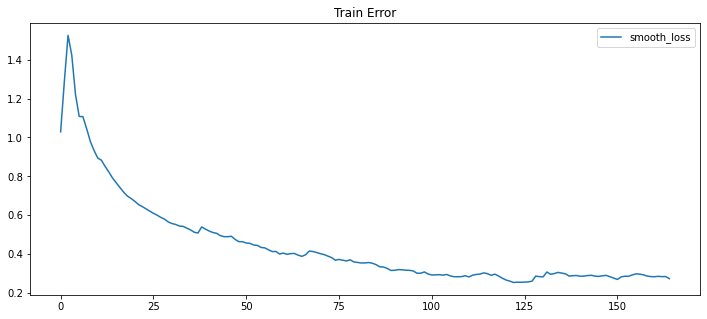

In [55]:
# Carregar dados do dataset de câncer de mama
data = load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N * 0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
y = torch.tensor(data.target).float().unsqueeze(1)  # Ajuste para classificação binária

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

# Criar DataLoader
batch_size = 32

train_loader = DataLoader(TensorDataset(Xtrain, ytrain), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(Xtest, ytest), batch_size=128, shuffle=False)

# Definir o modelo, agora diferene do MNIST só temos duas classes:
class ContinuousNeuralBreastCancerClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralBreastCancerClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True)
        )
        self.feature = ode
        self.fc = nn.Linear(64, 1)  # Ajuste para saída binária

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        out = self.fc(x)
        return out

class SimpleODEF(nn.Module):
    def __init__(self, hidden_dim):
        super(SimpleODEF, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, t, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class NeuralODE(nn.Module):
    def __init__(self, odef):
        super(NeuralODE, self).__init__()
        self.odef = odef

    def forward(self, x):
        return self.odef(0, x)

func = SimpleODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralBreastCancerClassifier(ode)
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento, aqui mudamos também a função de perda para BCEWithLogitsLoss
def train(epoch):
    model.train()
    criterion = nn.BCEWithLogitsLoss()
    train_losses = []
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, np.mean(train_losses)))
    return train_losses

# Função de teste
def test():
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = (torch.sigmoid(output) > 0.5).float()
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    return test_loss, accuracy

# Treinamento e avaliação
n_epochs = 15
train_losses = []
test_accuracies = []

test_loss, test_acc = test()
test_accuracies.append(test_acc)

for epoch in range(1, n_epochs + 1):
    train_losses.extend(train(epoch))
    test_loss, test_acc = test()
    test_accuracies.append(test_acc)

# Plotar histórico de treinamento
plt.figure(figsize=(12, 5))
history = pd.DataFrame({"loss": train_losses})
history["smooth_loss"] = history["loss"].ewm(halflife=10).mean()
history.plot(y="smooth_loss", figsize=(12, 5), title="Train Error")
plt.show()

Nas últimas epochs houve uma oscilação no erro, provavelmente nos beneficiaríamos de diminuir um pouco o learning rate, porém conseguímos a mesma acurácia do modelo implementado na lista de exercícios, os 94%.

## California Housing

Em aula foi implementada uma ridge regression com uma busca de hiperparâmetros para o coeficiente de regularização, o menor MSE que conseguimos foi 0.5356. Implementando ODENets para essa tarefa:

  0%|          | 0/363 [00:00<?, ?it/s]

100%|██████████| 363/363 [00:01<00:00, 211.71it/s]


Train Epoch: 1 	Loss: 5.617754
Validation set: Average loss: 0.0104



100%|██████████| 363/363 [00:01<00:00, 243.22it/s]


Train Epoch: 2 	Loss: 1.397254
Validation set: Average loss: 0.0198



100%|██████████| 363/363 [00:01<00:00, 219.43it/s]


Train Epoch: 3 	Loss: 1.421580
Validation set: Average loss: 0.0297



100%|██████████| 363/363 [00:01<00:00, 239.62it/s]


Train Epoch: 4 	Loss: 1.408610
Validation set: Average loss: 0.0087



100%|██████████| 363/363 [00:01<00:00, 226.47it/s]


Train Epoch: 5 	Loss: 1.109029
Validation set: Average loss: 0.0092

Test set: Average loss: 0.0091



<Figure size 864x360 with 0 Axes>

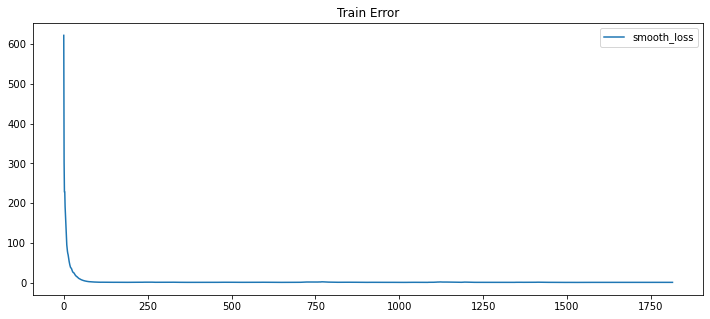

In [69]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Carregar dados do dataset California Housing
features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25, random_state=SEED
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25, random_state=SEED
)

# Converter para tensores do PyTorch
Xtrain = torch.tensor(features_train).float()
ytrain = torch.tensor(labels_train).float().unsqueeze(1)
Xval = torch.tensor(features_validation).float()
yval = torch.tensor(labels_validation).float().unsqueeze(1)
Xtest = torch.tensor(features_test).float()
ytest = torch.tensor(labels_test).float().unsqueeze(1)

# Criar DataLoader
batch_size = 32

train_loader = DataLoader(TensorDataset(Xtrain, ytrain), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(Xval, yval), batch_size=128, shuffle=False)
test_loader = DataLoader(TensorDataset(Xtest, ytest), batch_size=128, shuffle=False)

# Definir o modelo
class ContinuousNeuralHousingRegressor(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralHousingRegressor, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Linear(Xtrain.shape[1], 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True)
        )
        self.feature = ode
        self.fc = nn.Linear(64, 1)  # Ajuste para saída de regressão

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        out = self.fc(x)
        return out

class SimpleODEF(nn.Module):
    def __init__(self, hidden_dim):
        super(SimpleODEF, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, t, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class NeuralODE(nn.Module):
    def __init__(self, odef):
        super(NeuralODE, self).__init__()
        self.odef = odef

    def forward(self, x):
        return self.odef(0, x)

func = SimpleODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralHousingRegressor(ode)
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento
def train(epoch):
    model.train()
    criterion = nn.MSELoss()
    train_losses = []
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, np.mean(train_losses)))
    return train_losses

# Função de validação, aqui trocamos a perda para uma perda quadrática
def validate():
    model.eval()
    criterion = nn.MSELoss()
    val_loss = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            val_loss += criterion(output, target).item()
    
    val_loss /= len(val_loader.dataset)
    print('Validation set: Average loss: {:.4f}\n'.format(val_loss))
    return val_loss

# Função de teste
def test():
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
    
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

# Treinamento e avaliação
n_epochs = 5
train_losses = []
val_losses = []

for epoch in range(1, n_epochs + 1):
    train_losses.extend(train(epoch))
    val_loss = validate()
    val_losses.append(val_loss)

# Testar o modelo final
test_loss = test()

# Plotar histórico de treinamento
plt.figure(figsize=(12, 5))
history = pd.DataFrame({"loss": train_losses})
history["smooth_loss"] = history["loss"].ewm(halflife=10).mean()
history.plot(y="smooth_loss", figsize=(12, 5), title="Train Error")
plt.show()

A ODENet conseguiu uma perda quadrática de 0.0091 no conjunto de teste.

In [24]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchdiffeq import odeint_adjoint as odeint
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Constantes de normalização
img_mean = (0.5, 0.5, 0.5)
img_std = (0.5, 0.5, 0.5)

# Verificar se há suporte para GPU
use_cuda = torch.cuda.is_available()

# Tamanho do lote (batch size)
batch_size = 32

# Transformações para os dados de treinamento e teste
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std),
])

# Carregamento dos conjuntos de dados CIFAR-10
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

# Divisão do conjunto de treinamento em treinamento e validação
val_split = 0.1
train_size = int((1 - val_split) * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

# Criando DataLoaders
train_loader = DataLoader(
    train_subset, batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    val_subset, batch_size=batch_size, shuffle=False, num_workers=2
)

test_loader = DataLoader(
    test_set, batch_size=128, shuffle=False, num_workers=2
)

# Definição da função convolucional encapsulada em uma ODENet
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.conv1 = nn.Conv2d(dim + 1, dim, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(dim)
        self.conv2 = nn.Conv2d(dim + 1, dim, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(dim)

    def forward(self, t, x):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

# Classe Neural ODE que integra a função ODEFunc
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        self.integration_time = torch.tensor([0, 1]).float()
        self.ode_func = func

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.ode_func, x, self.integration_time, rtol=1e-3, atol=1e-3)
        return out[1]

# Adicionar tempo às entradas
def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

# Definir o modelo utilizando Neural ODE
class CIFAR10Classifier(nn.Module):
    def __init__(self, ode):
        super(CIFAR10Classifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = nn.BatchNorm2d(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

# Instanciar a função ODE e Neural ODE
func = ODEFunc(64)
ode = NeuralODE(func)
model = CIFAR10Classifier(ode)

# Mover modelo para GPU, se disponível
if use_cuda:
    model = model.cuda()

# Definir critério de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento
def train(epoch):
    model.train()
    train_losses = []
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch}, Train Loss: {np.mean(train_losses)}")
    return train_losses

# Função de teste
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, total=len(test_loader)):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}%")

# Número de épocas
n_epochs = 5

# Treinamento e teste do modelo
for epoch in range(1, n_epochs + 1):
    train_loss = train(epoch)
    test()

# Exibição de resultados (opcional)
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1407/1407 [27:22<00:00,  1.17s/it]


Epoch 1, Train Loss: 1.5135475613160936


100%|██████████| 79/79 [05:16<00:00,  4.01s/it]


Test Loss: 0.013081823360919953, Test Accuracy: 48.42%


 68%|██████▊   | 950/1407 [17:13<10:46,  1.41s/it]